# TAL - TD 1

On va recycler le code vu en CM (démo.ipynb), faire 2 encodages à la main, et utiliser des algos de classification:

# Plan du TP 

(détail et guidage plus bas, évidemment)


## 0. Chargement des données 
Cette partie est offerte par la maison ! On vous donne le code, qui est un copié-collé du code montré en cours magistral lors de la séance précédente: voir le fichier `TAL-1-démo de cours.ipynb` pour avoir plus d'explications.




## 1. Encodage
On va travailler l'encodage en le faisant à la main, pour tout de même bien comprendre. On fait ça sur le dataset des vidéos youtube sous-titrées:

    - 1.1 coder la méthode du sac de mots, avec CountVectorizer en backup,
    - 1.2 coder TF-IDF, avec TfidfVectorizer en backup.


## 2. Classification
Pour limiter l'overfitting en classification, on va prendre un plus gros dataset (20newsgroup, ou bien les 3 journaux). On utilise pour la suite les encodeurs de sklearn, qui sont sans erreurs et plus rapides que les votres)

    - 2.1 utiliser un modèle Bayésien Naïf (sans PCA) comme classifieur  (pour le sac de mot, vs TF-IDF)
    - 2.2 [optionnel] (si le temps permet) utiliser une PCA(D' variable)+k-NN(n variable) comme classifieur (pour le sac de mot, vs TF-IDF)



## 0. Chargement des données 
Cette partie est offerte par la maison ! On vous donne le code, qui est un copié-collé du code montré en cours magistral lors de la séance précédente: voir le fichier `TAL-1-démo de cours.ipynb` pour avoir plus d'explications.




In [3]:
import numpy as np
import matplotlib.pyplot as plt  ## classique pour les plots
import matplotlib.cm as cm
# import seaborn as sns            ## autre librairie pour faire de jolis plots
import sklearn.decomposition     ## Pour la PCA

## chargement des données:
import pandas as pd
import json  # pour importer des fichiers json
import warnings
warnings.filterwarnings("ignore") # retour au défaut : 'default'
from sklearn.datasets import fetch_20newsgroups ## partie 2.1 (plus gros jeu de données)

## tokenization manuelle:
import re ## regular expressions
from collections import Counter      # un package qui permet de faire un compteur d'occcurences (de types par exemple) en qq lignes.

from sklearn.feature_extraction.text import CountVectorizer ## partie 1.1, pour tricher/vérifier votre code.
from sklearn.feature_extraction.text import TfidfVectorizer ## partie 1.2, pour tricher/vérifier votre code.

import sklearn # partie 2
from sklearn.naive_bayes import MultinomialNB ## partie 2.1



### Chargement et Tokenization (offerts)

In [4]:
# un fichier json contenant les sous titres de plein de vidéos youtube
videos = json.loads(open('french_yt_videos.json').read())

themes_d_interet = ['Science & Technology', 'News & Politics', 'Comedy']
texts = []
ys = []
for i, entree in enumerate(videos):
    if videos[i]['category'] in themes_d_interet:
        texts.append(entree['text'].lower())
        ys   .append(entree['category'])
        
## tokenization (on vous la donne (rappelle))
regexp = r"\b\w+\b"
retoken = re.compile(regexp)
# tokenisons d'abord (texte par texte)
tokens = [retoken.findall(text) for text in texts]

# del texts ## ca éviterait d'oublier de prendre la version tokenizée.. mais sklearn en a besoin

In [5]:
## tokens est une liste de listes: chaque élément de tokens est un texte (document) du corpus, 
## et cet élément (un document) est lui meme une liste de tokens
## on peut regarder par exemple les 20 premiers tokens du premier texte:
tokens[0] [:20]

['bonjour',
 'je',
 'm',
 'appelle',
 'elodie',
 'et',
 'je',
 'travaille',
 'chez',
 'proximus',
 'vous',
 'trouvez',
 'que',
 'les',
 'lumières',
 'de',
 'votre',
 'modem',
 'b',
 'box']

In [6]:
## il nous reste combien de points de données (=combien de documents dans notre corpus) ?
N = len(tokens)
N

130

In [7]:
## on passe les labels sous forme numérique, c'est parfois pratique:
## (ça nous servira seulement au moment de classifier)
encoder = sklearn.preprocessing.LabelEncoder()
y_numerique = encoder.fit_transform(ys)
y_numerique

array([2, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 2, 1, 0, 0, 0, 1, 0, 2, 1,
       0, 2, 0, 2, 1, 0, 1, 0, 0, 0, 0, 2, 1, 0, 2, 0, 0, 0, 0, 2, 1, 1,
       1, 1, 1, 0, 0, 2, 0, 0, 1, 0, 0, 1, 0, 0, 2, 0, 0, 0, 1, 0, 1, 2,
       0, 0, 0, 2, 2, 0, 1, 0, 1, 1, 0, 1, 1, 2, 1, 0, 0, 2, 0, 0, 0, 0,
       1, 2, 1, 0, 0, 0, 2, 1, 0, 2, 0, 0, 0, 1, 0, 2, 0, 1, 0, 2, 1, 2,
       1, 2, 0, 1, 0, 1, 2, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 2, 1, 0],
      dtype=int64)

## 1. Encodage
On va travailler l'encodage en le faisant à la main, pour tout de même bien comprendre. On fait ça sur le dataset des vidéos youtube sous-titrées:

    - 1.1 coder la méthode du sac de mots, avec CountVectorizer en backup,
    - 1.2 coder TF-IDF, avec TfidfVectorizer en backup.


### 1.1 Coder la méthode du sac de mots, avec CountVectorizer en backup:

Faire la vectorisation en sac ce mots à la main (c.a.d, le calcul des vecteurs one-hot qui ont en fait plusieurs points "hots" (plusieurs 1 et pas un seul 1 dans le vecteur), avec une ou deux boucles).
On vous guide plus bas.
- recenser tous les types à mettre dans le vocabulaire à l'aide d'un `set` ou d'un `dict`. Compter combien vous avez de types différents (c'est la taille du vocabulaire, notée $V$).
- Définir un `dict` qui enverra chaque type (une `str`) vers un indice (les `set` ne sont pas itérables de façon stable, d'ou le passage préférable vers cette table type->indice)
- définir le `np.array` qui servira de résultat (notre X pour ensuite faire du Machine Learning)
- passer en revue chaque texte d'intérêt, et:
    - pour chaque token du texte, 
        - si il fait partie des types sélectionnés dans notre vocabulaire, noter son apparition (sinon, rien)
- afficher le résultat (ou plutot des extraits), comparer à la vectorisation faite par sklearn, pour vérifier.

Bonus: dans le vocabulaire, quand un mot n'apparait que 1 fois dans le corpus, ne pas le mettre dans le vocabulaire.


#### TODO: 
En utilisant la methode .update() associée aux objets de type `set` de python, définir le vocabulaire.

Puis compter sa taille. On doit trouver 15030.

In [8]:
Vocabulaire = set()
## TODO
mot = set()

for i in range(len(tokens)) :
    for j in range(len(tokens[i])) :
        mot.add(tokens[i][j])
Vocabulaire.update(mot)
V = len(Vocabulaire)

In [9]:
len(Vocabulaire)

15030

#### TODO: 
Définir un dict qui pour chaque type, donne un indice

In [10]:
token2index ={}
## TODO
for  i, v in enumerate(Vocabulaire) :
    token2index[v] = i
token2index

{'bits': 0,
 'fonctionné': 1,
 'perception': 2,
 'équilibre': 3,
 'croisée': 4,
 'émergé': 5,
 'accouchement': 6,
 'aléatoire': 7,
 'plastique': 8,
 'comme': 9,
 'principales': 10,
 'élèves': 11,
 'idée': 12,
 'totalement': 13,
 'improvisé': 14,
 'considérons': 15,
 'métriques': 16,
 'auriez': 17,
 'toile': 18,
 'talents': 19,
 'récapitule': 20,
 'hentais': 21,
 'faces': 22,
 'singulière': 23,
 'épargné': 24,
 'guolrire': 25,
 'roumains': 26,
 'head': 27,
 'canberra': 28,
 'efficaces': 29,
 'fabriquer': 30,
 'champagne': 31,
 'modeler': 32,
 'lutins': 33,
 'incestueux': 34,
 'frustration': 35,
 'ambiguïté': 36,
 'usb': 37,
 'labo': 38,
 'apparaissaient': 39,
 'vibrer': 40,
 'baggy': 41,
 'nulles': 42,
 'foutent': 43,
 'aux': 44,
 'briser': 45,
 'batte': 46,
 'viral': 47,
 'pêter': 48,
 'phalanges': 49,
 'sg': 50,
 'diplômés': 51,
 'détiennent': 52,
 'oula': 53,
 'empruntés': 54,
 'existe': 55,
 'economics': 56,
 'bureaux': 57,
 'régal': 58,
 'spermatique': 59,
 'vis': 60,
 'cassent': 6

#### TODO :
Définir un array de zéros qu'on peut appeler X, qui donnera en ligne n, colonne v, la valeur booleene "est ce que le type numéro v est présent dans le texte numéro n".

Ce calcul doit prendre un temps $O(N.V)+O($[nombre de tokens du corpus]$)$, mais pas $O(N.V^2)$ ou autre.

In [11]:
## TODO
X = np.zeros((N,V))
for n in range(N) :
    for tok in tokens[n] :
        v = token2index[tok]
        X[n, v] = 1

In [12]:
X.sum(axis=1)  #comptage du nombre de tokens differents (pour comparaison avec sklearn)

array([235., 702., 608., 644., 501., 727., 226., 706., 726., 486., 302.,
       373., 663., 325., 747., 393., 365., 362., 213., 494., 808., 497.,
       282., 593., 295., 697., 432., 286., 452., 445., 462., 336., 832.,
       641., 226., 306., 691., 413., 544., 576., 372., 705., 399., 683.,
       404., 700., 485., 553., 574., 823., 569., 279., 419., 446., 503.,
       373., 459., 383., 220., 476., 170., 384., 715., 352., 244., 519.,
       629., 466., 676., 413., 860., 290., 277., 356., 297., 656., 508.,
       498., 472., 700., 642., 497., 242., 831., 335., 315., 628., 582.,
       471., 506., 461., 314., 749., 314., 556., 721., 327., 413., 261.,
       866., 453., 277., 511., 449., 259., 553., 269., 418., 381., 106.,
       444., 497., 404., 413., 318., 412., 941., 318., 297., 533., 755.,
       637., 365., 283., 723., 331., 767., 299., 515., 283.])

#### Vérification par comparaison avec sklearn:

Attention, l'ordre du Vocabulaire utilisé par sklearn ne sera pas forcément le meme que le votre, par défaut.
Vous pouvez donc aussi lui fournir votre propre vocabulaire (2 choix possibles)

In [13]:
# regexp = r"\b\w+\b"
skVocabulaire = None
# skVocabulaire = list(Vocabulaire)
skSacDeMot = CountVectorizer(vocabulary=skVocabulaire, binary=True, token_pattern=regexp)
X_sacDeMots = skSacDeMot.fit_transform(texts)
X_sacDeMots = X_sacDeMots.toarray()
X_sacDeMots.sum(axis=1)  #comptage du nombre de tokens differents

array([235, 702, 608, 644, 501, 727, 226, 706, 726, 486, 302, 373, 663,
       325, 747, 393, 365, 362, 213, 494, 808, 497, 282, 593, 295, 697,
       432, 286, 452, 445, 462, 336, 832, 641, 226, 306, 691, 413, 544,
       576, 372, 705, 399, 683, 404, 700, 485, 553, 574, 823, 569, 279,
       419, 446, 503, 373, 459, 383, 220, 476, 170, 384, 715, 352, 244,
       519, 629, 466, 676, 413, 860, 290, 277, 356, 297, 656, 508, 498,
       472, 700, 642, 497, 242, 831, 335, 315, 628, 582, 471, 506, 461,
       314, 749, 314, 556, 721, 327, 413, 261, 866, 453, 277, 511, 449,
       259, 553, 269, 418, 381, 106, 444, 497, 404, 413, 318, 412, 941,
       318, 297, 533, 755, 637, 365, 283, 723, 331, 767, 299, 515, 283],
      dtype=int64)

## On visualise nos textes à l'aide d'une PCA 
(déjà vu en cours)

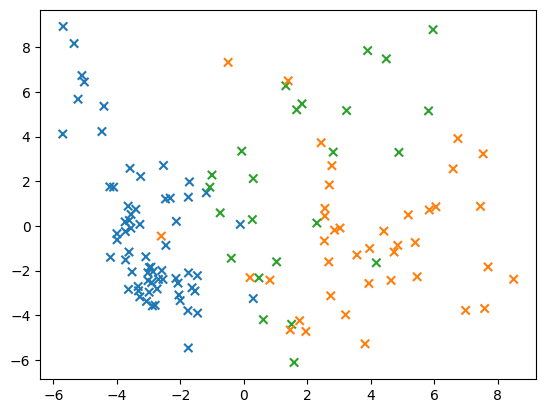

In [14]:
maPCA = sklearn.decomposition.PCA(n_components=2)
maPCA.fit(X_sacDeMots)
X_transformee = maPCA.transform(X_sacDeMots)

mycolorBar = cm.tab10
plt.figure()
plt.scatter(X_transformee[:,0], X_transformee[:,1], c=mycolorBar(y_numerique), marker= 'x')

### Conclusion: c'est plutot prometteur

## 1.2 coder TF-IDF, avec sklearn en backup.

- Définir le `np.array` qui servira de résultat (notre `X_TFIDF` pour ensuite faire du Machine Learning)
- Calcul du IDF:
    - Calculer le *document frequency* DF brut de chaque token, c.a.d. pour chaque token, le nombres de documents où le token apparaît au moins 1 fois, **sans diviser par le nombre de documents**. Astuce: utilisez le vecteur X (sac de mot, vecteur ne-hot) calculé juste avant.
    - Le IDF du token est alors $np.log\left( \frac{Ndocs+1}{DF+1} \right) + 1$  (on ajoute les +1 pour éviter de diviser par 0)
- Pour chaque texte d'intérêt, calculer 
    - pour chacun de ses tokens, 
        - la *term frequency* TF, c.a.d. en fait le nombre d'occurces de ce token dans ce texte 
        - Le résultat (TF) permet de déduire  (pour chaque texte, et chaque type du vocabulaire), le score TF-IDF du token (notez que le score est 0 pour les types absents du texte).
        - stockez le résultat dans votre `X_TFIDF`.
- afficher le résultat (ou plutot des extraits), comparer à la vectorisation faite par sklearn, pour vérifier.

Il est recommandé de ne pas faire de boucle qui implique tous les types du vocabulaire: mieux vaut boucler sur les tokens d'un texte (même si certains apparaissent plusieurs fois) 

In [15]:
## on calcule la Inverse Document Frequency:
Ndocs = X.shape[0]

DF = X.sum(axis= 0)
IDF = np.log(Ndocs + 1 / (DF + 1)) + 1

In [16]:
## le code pour la Term frequency esy tres tres semblable au code du Sac de mot:
TF = np.zeros((N,V))
for n in range(N) :
    for tok in tokens[n] :
        v = token2index[tok]
        TF[n, v] += 1

In [17]:
X_TFIDF = (TF * IDF)

In [18]:
X_TFIDF.sum(1)

array([ 3121.98373594, 10111.31324444, 10832.37254452,  8996.55001387,
        6959.73518103, 16999.53006185,  2687.56512147, 11137.99901748,
       10058.53842199,  7816.39071236,  5169.62897213,  6184.89407357,
       11736.34277507,  9799.8154158 , 14664.43596756,  5955.94100311,
        5955.961252  ,  6143.75304325,  2646.52547842,  8555.47022779,
       15098.92719753,  7828.2078858 ,  4113.45089718, 12346.39544467,
        4706.13750385, 13837.07169679,  5627.70621521,  3890.52873116,
        7552.23545184,  9693.86365933,  7804.43680113,  4858.71992231,
       18918.42825843, 16465.85458723,  2898.84635396,  5287.02548956,
       12217.55058529,  5627.48196839,  8543.92132013,  9612.07050722,
        7282.08059055, 14206.52674714,  6807.17491455, 13344.17144446,
        5140.5171658 , 11437.01954132,  7247.29700727,  8344.47695277,
       14041.96031951, 15609.60839965,  9371.36318931,  3966.80592439,
        9676.36170604,  7780.93697629,  8168.26917776,  5052.53967824,
      

## Vérification de notre TF-IDF avec TfidfVectorizer:


In [19]:
skTFIDF_vectorizer = TfidfVectorizer(token_pattern=regexp, min_df=0, norm=None, stop_words=None) 
## maybe more non-default choices will be needed to match our naive TF-IDF
skX_TFIDF = skTFIDF_vectorizer.fit_transform(texts)
skX_TFIDF = skX_TFIDF.toarray()
skX_TFIDF.shape

(130, 15030)

In [20]:
skX_TFIDF.sum(1)

array([1281.37443179, 4363.25418556, 3697.9226284 , 4124.99838099,
       2654.70454655, 5640.28020703,  929.85820933, 4344.09631295,
       4405.89754054, 2864.96987794, 1632.41801076, 2029.17565998,
       4421.94405293, 3516.66280345, 5193.13029056, 1916.14213389,
       1970.7295089 , 1990.23658734,  947.80737751, 2785.97447309,
       5668.24316581, 3019.65598486, 1345.23255433, 4141.53975711,
       1532.79119138, 5066.6496175 , 2319.45070136, 1392.76637565,
       2686.3956333 , 3122.57309278, 2669.977101  , 1621.40438026,
       6243.49580675, 5843.50201201, 1025.08763259, 1672.68590648,
       4527.51022446, 2001.76246615, 3029.54111965, 3530.70300797,
       2249.28525667, 4836.48946085, 2589.81099245, 4906.8105772 ,
       1879.2453714 , 4201.88787497, 2793.38195148, 2992.41544241,
       4247.79446422, 5958.99703452, 3291.58093643, 1346.969684  ,
       3140.50003593, 2613.73230394, 2789.08114531, 1912.76842104,
       2486.22027863, 1869.44749357, 1192.99498454, 3044.19813

## On visualise nos textes à l'aide d'une PCA 

(on peut aussi comparer les PCA de notre version du code et de sklearn, pour voir si ça ressemble, si jamais les 2 outputs ne sont pas exactement identiques)


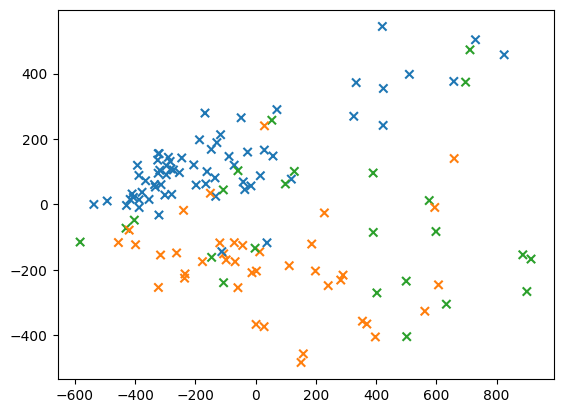

In [21]:
maPCA = sklearn.decomposition.PCA(n_components=3)
maPCA.fit(X_TFIDF)
X_transformee = maPCA.transform(X_TFIDF)

mycolorBar = cm.tab10
plt.figure()
plt.scatter(X_transformee[:,0], X_transformee[:,1], c=mycolorBar(y_numerique), marker= 'x')

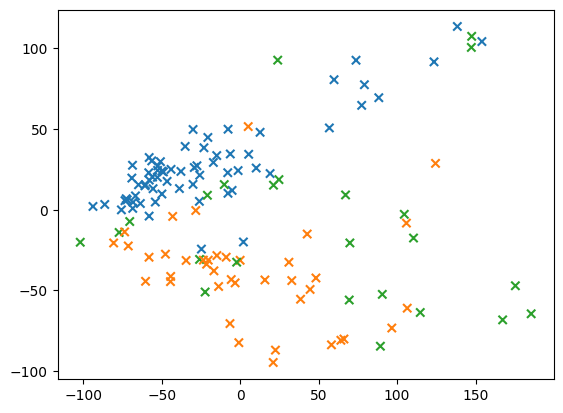

In [22]:
maPCA = sklearn.decomposition.PCA(n_components=3)
maPCA.fit(skX_TFIDF)
X_transformee = maPCA.transform(skX_TFIDF)

mycolorBar = cm.tab10
plt.figure()
plt.scatter(X_transformee[:,0], X_transformee[:,1], c=mycolorBar(y_numerique), marker= 'x')

### Conclusion: ??

## 2. Classification

On utilise pour la suite les encodeurs de sklearn, qui sont sans erreurs et plus rapides que les votres)

    - 2.1 utiliser un modèle Bayésien Naïf (sans PCA) comme classifieur  (pour le sac de mot, vs TF-IDF)
    - 2.2 [optionnel] (si le temps permet) utiliser une PCA(D' variable)+k-NN(n variable) comme classifieur (pour le sac de mot, vs TF-IDF)


## 2.1 Bayesien Naïf

- faire un train/test split de votre X,y (sac de mots) (utilisez `sklearn.model_selection.train_test_split`)
- entrainer un classifieur `sklearn.naive_bayes.MultinomialNB`
- calculer le score de cross-validation (jouer avec des hyper-paramètre éventuellement), pour les deux choix de pre-processing (sac de mot vs TF-IDF) (Utilisez `sklearn.model_selection.cross_validate`). Prenez par exemple cv=10 plis de cross-validation

- Refaire tout ça en utilisant le TF-IDF à la place du sac de mots.
- pour le meilleur des deux, calculer le test score

In [26]:
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y_numerique, test_size=0.2)

## Conclusion:  

conclure ! Lequel est le meilleur ?

## Refaire la meme chose avec un plus gros dataset:

Pour limiter l'overfitting en classification, on va prendre un plus gros dataset (20newsgroup).

In [ ]:
## le train/test split est déja fourni:
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
newsgroups_test  = fetch_20newsgroups(subset='test',  remove=('headers', 'footers', 'quotes'))

In [ ]:
newsgroups_train.keys()

In [ ]:
newsgroups_train.target_names

In [ ]:
newsgroups_train.data[1], newsgroups_train.target_names[newsgroups_train.target[1]]

In [ ]:
y_trainval = newsgroups_train.target
y_test  = newsgroups_test.target

In [ ]:
## Aide: pensez au vectorizer ou TFIDF comme a une PCA : il y a un fit et un transform.
## Sur quel ensemble applique t on le fit ?


In [ ]:
## pour la cross-validation, a qui l'applique t'on ?

## conclusion: lequel est le meilleur ?

On peut maintenant calculer la test error:


In [ ]:
## remarque: quel(s) ensemble de données peut on utiliser pour faire le fit ? Parmi Train, val, test ?


## Conclusion:


## 2.2 Bonus: PCA + SVM

Faire la classification avec le meilleur pre-processing, mais cette fois ci avec PCA+SVM. Optimiser `n_components` et `C`, par exemple (avec cross-validation évidemment, pas sur le test set !)